# 커피지수로 본 지역발전 정도
- (스타벅스 + 커피빈) / (이디야 + 빽다방)
- [데이터 출처](https://www.data.go.kr/dataset/15012005/fileData.do)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['axes.unicode_minus'] = False   # minus 표시
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 10

## 데이터 읽기

In [2]:
df1 = pd.read_csv('소상공인_201906/소상공인시장진흥공단_상가업소정보_201906_01.csv', encoding='utf-8')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565016 entries, 0 to 565015
Data columns (total 39 columns):
상가업소번호       565016 non-null int64
상호명          565015 non-null object
지점명          75524 non-null object
상권업종대분류코드    565016 non-null object
상권업종대분류명     565016 non-null object
상권업종중분류코드    565016 non-null object
상권업종중분류명     565016 non-null object
상권업종소분류코드    565016 non-null object
상권업종소분류명     565016 non-null object
표준산업분류코드     532064 non-null object
표준산업분류명      532064 non-null object
시도코드         565016 non-null int64
시도명          565016 non-null object
시군구코드        565016 non-null int64
시군구명         565016 non-null object
행정동코드        565016 non-null int64
행정동명         565016 non-null object
법정동코드        565016 non-null int64
법정동명         565016 non-null object
지번코드         565016 non-null int64
대지구분코드       565016 non-null int64
대지구분명        565016 non-null object
지번본번지        565016 non-null int64
지번부번지        467893 non-null float64
지번주소         565016 non-null obje

In [3]:
df2 = pd.read_csv('소상공인_201906/소상공인시장진흥공단_상가업소정보_201906_02.csv', encoding='utf-8')
df3 = pd.read_csv('소상공인_201906/소상공인시장진흥공단_상가업소정보_201906_03.csv', encoding='utf-8')
df4 = pd.read_csv('소상공인_201906/소상공인시장진흥공단_상가업소정보_201906_04.csv', encoding='utf-8')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df2.shape, df3.shape, df4.shape

((520497, 39), (857672, 39), (758611, 39))

In [5]:
df = pd.concat([df1, df2, df3, df4])
df.shape

(2701796, 39)

In [6]:
df = df[df['상권업종소분류명'].str.contains('커피')]
df.shape

(93253, 39)

In [7]:
df.to_csv('coffee/커피업소정보.csv', index=False, encoding='euc-kr')

In [8]:
df = df[['상호명', '시도명', '시군구명', '도로명주소']]
df.head()

,상호명,시도명,시군구명,도로명주소
0,커피빈코리아선릉로93길점,서울특별시,강남구,서울특별시 강남구 선릉로93길 6
10,스완카페트,서울특별시,영등포구,서울특별시 영등포구 도신로10가길 11-1
16,왕실,서울특별시,중구,서울특별시 중구 남대문로 52-13
20,커피빈,서울특별시,서초구,서울특별시 서초구 서초중앙로 118
22,고려대학교교육관쎄리오점,서울특별시,성북구,서울특별시 성북구 안암로 145


## 지도 처리를 위한 공통 모듈

In [9]:
tmp_gu_dict = {'수원':['장안구', '권선구', '팔달구', '영통구'], 
               '성남':['수정구', '중원구', '분당구'], 
               '안양':['만안구', '동안구'], 
               '안산':['상록구', '단원구'], 
               '고양':['덕양구', '일산동구', '일산서구'], 
               '용인':['처인구', '기흥구', '수지구'], 
               '청주':['상당구', '서원구', '흥덕구', '청원구'], 
               '천안':['동남구', '서북구'], 
               '전주':['완산구', '덕진구'], 
               '포항':['남구', '북구'], 
               '창원':['의창구', '성산구', '진해구', '마산합포구', '마산회원구'], 
               '부천':['오정구', '원미구', '소사구']}

In [10]:
def GetID(dfarg):
    for n in dfarg.index:
        if dfarg['시도명'][n][-3:] not in ['광역시', '특별시', '자치시']:  # 광역시도 열에서 뒷 세자리가 '광역시', '특별시', '자치시' 가 아니면,
        
            # 같은 '시도' 이름을 가지는 고성 지역 처리
            if dfarg['시군구명'][n].strip()[:-1]=='고성' and dfarg['시도명'][n]=='강원도':  # '시도'가 고성이면서, '광역시도'가 강원도인 지역 처리
                si_name[n] = '고성(강원)'
            elif dfarg['시군구명'][n].strip()[:-1]=='고성' and dfarg['시도명'][n]=='경상남도':  # '시도'가 고성이면서, '광역시도가' 경남인 지역 처리
                si_name[n] = '고성(경남)'
            else:
                si_name[n] = dfarg['시군구명'][n].strip()[:-1]  # 나머지 지역은 맨 뒤의 '구' 삭제 
        
            # 광역시가 아니면서 구를 가지고 있는 시 처리 
            for keys, values in tmp_gu_dict.items():
                if len(dfarg['시군구명'][n]) >= 5 and dfarg['시군구명'][n].strip()[:2] in keys:
                    if len(dfarg['시군구명'][n].split()[1]) == 2:
                        si_name[n] = keys + ' ' + dfarg['시군구명'][n].split()[1]
                    elif dfarg['시군구명'][n] in ['마산합포구','마산회원구']:  # 마산합포와 회원구는 '합포', '회원'만 출력
                        si_name[n] = keys + ' ' + dfarg['시군구명'][n].strip()[2:-1]
                    else:
                        si_name[n] = keys + ' ' + dfarg['시군구명'][n].strip()[4:-1]  # 이름이 3자 이상이면, 맨 뒤의 '구' 삭제  
        
        elif dfarg['시도명'][n] == '세종특별자치시':  # 세종자치시의 경우는 세종으로
            si_name[n] = '세종'
        
        else:  # tmp_gi_dict와 세종을 제외한 나머지 지역 처리 
            if len(dfarg['시군구명'][n].strip()) >= 3:
                si_name[n] = dfarg['시도명'][n][:2] + ' ' + dfarg['시군구명'][n].strip()[:-1]
            else:
                si_name[n] = dfarg['시도명'][n][:2] + ' ' + dfarg['시군구명'][n].strip()
        
        print(si_name[n], n)

## 스타벅스 전처리

In [31]:
starbucks = df[df['상호명'].str.contains('스타벅스')]
len(starbucks)

1433

In [32]:
starbucks = starbucks.reset_index()
starbucks.head()

,index,상호명,시도명,시군구명,도로명주소
0,1219,스타벅스,서울특별시,용산구,서울특별시 용산구 이태원로 188
1,1946,스타벅스종로3가점,서울특별시,종로구,서울특별시 종로구 종로 113-1
2,2840,스타벅스,서울특별시,서초구,서울특별시 서초구 강남대로 581
3,14939,스타벅스커피여의도IFC1F,서울특별시,영등포구,서울특별시 영등포구 국제금융로 10
4,14951,스타벅스,서울특별시,강남구,서울특별시 강남구 테헤란로103길 9


In [33]:
starbucks = starbucks.drop('index', axis=1)
starbucks.tail()

,상호명,시도명,시군구명,도로명주소
1428,스타벅스,경상남도,창원시 마산회원구,경상남도 창원시 마산회원구 315대로 715
1429,스타벅스,경상남도,김해시,경상남도 김해시 김해대로 1918
1430,스타벅스,전라남도,순천시,전라남도 순천시 연향번영길 118
1431,스타벅스,충청남도,아산시,충청남도 아산시 배방읍 배방로 22
1432,스타벅스,전라북도,익산시,전라북도 익산시 선화로 106


In [34]:
starbucks.index

RangeIndex(start=0, stop=1433, step=1)

In [35]:
si_name = [None] * len(starbucks)
GetID(starbucks)

서울 용산 0
서울 종로 1
서울 서초 2
서울 영등포 3
서울 강남 4
서울 관악 5
서울 관악 6
서울 강동 7
서울 마포 8
서울 강남 9
서울 영등포 10
서울 마포 11
서울 종로 12
서울 강서 13
서울 송파 14
서울 종로 15
서울 은평 16
서울 강남 17
서울 서대문 18
서울 송파 19
서울 동대문 20
서울 동작 21
서울 영등포 22
서울 송파 23
서울 성북 24
서울 서초 25
서울 서대문 26
서울 강남 27
서울 강남 28
서울 서초 29
서울 강남 30
서울 서대문 31
서울 중구 32
부산 해운대 33
서울 서대문 34
부산 남구 35
서울 서대문 36
서울 중구 37
서울 서초 38
서울 관악 39
서울 용산 40
서울 관악 41
서울 강남 42
서울 관악 43
서울 강서 44
서울 광진 45
서울 강서 46
서울 강남 47
서울 성북 48
서울 광진 49
서울 영등포 50
서울 송파 51
서울 서대문 52
서울 중구 53
서울 중구 54
서울 강남 55
서울 광진 56
서울 중랑 57
서울 서대문 58
서울 성북 59
서울 종로 60
서울 중구 61
서울 서초 62
서울 성북 63
서울 송파 64
서울 강동 65
서울 영등포 66
서울 서대문 67
부산 남구 68
서울 서초 69
서울 서초 70
서울 강남 71
서울 강남 72
부산 수영 73
서울 금천 74
부산 동래 75
부산 북구 76
서울 중구 77
서울 강남 78
부산 금정 79
부산 동구 80
서울 종로 81
서울 강남 82
서울 용산 83
부산 부산진 84
서울 마포 85
서울 강동 86
서울 광진 87
서울 서초 88
부산 동래 89
서울 노원 90
서울 중구 91
부산 중구 92
서울 강북 93
서울 서대문 94
서울 서초 95
서울 동대문 96
서울 강남 97
서울 서초 98
서울 마포 99
서울 종로 100
부산 북구 101
부산 사하 102
부산 해운대 103
서울 서초 104
서울 종로 105
서울 구로 106
서울 서초 107
서울 강남 108
서

수원 권선 884
원주 885
김포 886
고양 일산서 887
충주 888
성남 분당 889
구리 890
성남 중원 891
안양 동안 892
수원 영통 893
수원 영통 894
성남 분당 895
광주 896
수원 팔달 897
성남 분당 898
홍천 899
용인 수지 900
성남 분당 901
용인 수지 902
오산 903
성남 분당 904
부천 905
고양 덕양 906
광명 907
군포 908
부천 909
성남 분당 910
부천 911
고양 일산동 912
시흥 913
수원 권선 914
수원 영통 915
청주 흥덕 916
양주 917
청주 흥덕 918
안양 만안 919
고양 덕양 920
김포 921
안양 동안 922
군포 923
고양 일산서 924
성남 분당 925
오산 926
수원 장안 927
고양 일산동 928
성남 분당 929
용인 기흥 930
수원 팔달 931
청주 상당 932
고성(강원) 933
성남 분당 934
청주 흥덕 935
수원 팔달 936
용인 수지 937
수원 팔달 938
부천 939
청주 흥덕 940
춘천 941
청주 서원 942
고양 일산동 943
이천 944
고양 일산동 945
충주 946
충주 947
성남 분당 948
용인 수지 949
용인 기흥 950
성남 분당 951
부천 952
김포 953
성남 분당 954
성남 분당 955
성남 분당 956
화성 957
성남 분당 958
성남 분당 959
수원 팔달 960
안산 단원 961
성남 분당 962
하남 963
안양 만안 964
성남 분당 965
부천 966
용인 기흥 967
파주 968
용인 기흥 969
이천 970
청주 상당 971
청주 청원 972
이천 973
부천 974
남양주 975
속초 976
고양 일산동 977
의정부 978
파주 979
구리 980
용인 수지 981
안양 동안 982
안양 동안 983
성남 분당 984
안양 동안 985
성남 분당 986
성남 분당 987
성남 분당 988
용인 처인 989
성남 분당 990
안성 991
성남 분당 992
강릉 993
수원 영

In [36]:
starbucks['ID'] = si_name
starbucks['브랜드명'] = '스타벅스'
starbucks['스타벅스 매장수'] = 1
starbucks.head()

,상호명,시도명,시군구명,도로명주소,ID,브랜드명,스타벅스 매장수
0,스타벅스,서울특별시,용산구,서울특별시 용산구 이태원로 188,서울 용산,스타벅스,1
1,스타벅스종로3가점,서울특별시,종로구,서울특별시 종로구 종로 113-1,서울 종로,스타벅스,1
2,스타벅스,서울특별시,서초구,서울특별시 서초구 강남대로 581,서울 서초,스타벅스,1
3,스타벅스커피여의도IFC1F,서울특별시,영등포구,서울특별시 영등포구 국제금융로 10,서울 영등포,스타벅스,1
4,스타벅스,서울특별시,강남구,서울특별시 강남구 테헤란로103길 9,서울 강남,스타벅스,1


## 커피빈 전처리

In [17]:
coffeebean = df[df['상호명'].str.contains('커피빈')]
len(coffeebean)

374

In [18]:
coffeebean = coffeebean.reset_index().drop('index', axis=1)
coffeebean.tail()

,상호명,시도명,시군구명,도로명주소
369,커피빈,전라북도,전주시 완산구,전라북도 전주시 완산구 속거길 11-8
370,커피빈,경상남도,창원시 진해구,경상남도 창원시 진해구 안청남로 40
371,커피빈,전라남도,여수시,전라남도 여수시 대학로 18-1
372,커피빈,전라북도,군산시,전라북도 군산시 미원로 126-6
373,커피빈,경상북도,울진군,경상북도 울진군 죽변면 죽변9길 1


In [19]:
si_name = [None] * len(coffeebean)
GetID(coffeebean)

서울 강남 0
서울 서초 1
서울 종로 2
서울 강남 3
서울 영등포 4
서울 강남 5
서울 서대문 6
서울 강남 7
서울 강남 8
서울 강남 9
서울 강남 10
서울 광진 11
서울 중구 12
서울 강남 13
서울 강남 14
서울 서초 15
서울 강남 16
서울 서초 17
서울 강남 18
서울 서대문 19
서울 강남 20
서울 관악 21
서울 강남 22
서울 서초 23
서울 양천 24
서울 강남 25
서울 서초 26
서울 성북 27
서울 서대문 28
서울 용산 29
서울 중구 30
서울 강남 31
서울 은평 32
서울 구로 33
서울 강남 34
서울 영등포 35
서울 강동 36
서울 관악 37
서울 강남 38
서울 양천 39
서울 종로 40
서울 금천 41
서울 금천 42
부산 해운대 43
서울 중구 44
서울 구로 45
서울 영등포 46
서울 용산 47
서울 강동 48
서울 종로 49
서울 영등포 50
서울 서초 51
서울 강남 52
서울 광진 53
서울 서초 54
서울 서대문 55
서울 강남 56
서울 강동 57
서울 강서 58
서울 강남 59
서울 중랑 60
서울 중구 61
서울 강남 62
서울 강남 63
서울 강동 64
서울 종로 65
서울 강남 66
서울 강남 67
서울 영등포 68
서울 마포 69
서울 영등포 70
서울 중구 71
서울 영등포 72
서울 강남 73
서울 송파 74
서울 강남 75
서울 영등포 76
서울 강남 77
부산 중구 78
서울 서대문 79
서울 강남 80
서울 서초 81
서울 중구 82
서울 동대문 83
서울 강남 84
서울 종로 85
서울 중구 86
서울 강남 87
서울 중구 88
서울 강남 89
서울 영등포 90
서울 강남 91
서울 서초 92
서울 양천 93
서울 강남 94
서울 서초 95
서울 강남 96
서울 영등포 97
서울 강남 98
서울 송파 99
서울 서초 100
서울 종로 101
서울 강남 102
서울 영등포 103
서울 서초 104
서울 강남 105
서울 강남 106
서울 마포 107
서울 성북 108
서울

In [20]:
coffeebean['ID'] = si_name
coffeebean['브랜드명'] = '커피빈'
coffeebean['커피빈 매장수'] = 1
coffeebean.head()

,상호명,시도명,시군구명,도로명주소,ID,브랜드명,커피빈 매장수
0,커피빈코리아선릉로93길점,서울특별시,강남구,서울특별시 강남구 선릉로93길 6,서울 강남,커피빈,1
1,커피빈,서울특별시,서초구,서울특별시 서초구 서초중앙로 118,서울 서초,커피빈,1
2,커피빈,서울특별시,종로구,서울특별시 종로구 대명길 25,서울 종로,커피빈,1
3,커피빈,서울특별시,강남구,서울특별시 강남구 테헤란로 335,서울 강남,커피빈,1
4,커피빈,서울특별시,영등포구,서울특별시 영등포구 국제금융로 20,서울 영등포,커피빈,1


## 이디야 전처리

In [21]:
ediya = df[df['상호명'].str.contains('이디야')]
len(ediya)

2029

In [22]:
ediya = ediya.reset_index().drop('index', axis=1)
ediya.tail()

,상호명,시도명,시군구명,도로명주소
2024,이디야커피,경상남도,김해시,경상남도 김해시 호계로422번길 16
2025,이디야커피,경상북도,울진군,경상북도 울진군 울진읍 읍내8길 5
2026,이디야커피,경상남도,김해시,경상남도 김해시 진영읍 진산대로 63-31
2027,이디야커피,경상북도,청도군,경상북도 청도군 화양읍 이슬미로 321
2028,이디야커피,전라남도,여수시,전라남도 여수시 대교로 30


In [23]:
si_name = [None] * len(ediya)
GetID(ediya)

서울 영등포 0
부산 사하 1
서울 구로 2
서울 노원 3
서울 성동 4
서울 강남 5
서울 종로 6
서울 용산 7
서울 종로 8
서울 동대문 9
서울 서대문 10
부산 영도 11
서울 중구 12
부산 부산진 13
서울 동작 14
서울 금천 15
서울 도봉 16
서울 송파 17
서울 중구 18
서울 노원 19
서울 중구 20
부산 동래 21
서울 동대문 22
서울 중구 23
서울 은평 24
서울 서초 25
서울 성북 26
서울 성동 27
부산 남구 28
부산 해운대 29
서울 은평 30
서울 광진 31
서울 중구 32
서울 강북 33
서울 구로 34
서울 강동 35
부산 영도 36
부산 중구 37
서울 서대문 38
서울 송파 39
서울 광진 40
서울 강서 41
서울 성동 42
부산 서구 43
부산 해운대 44
서울 동작 45
서울 광진 46
부산 부산진 47
서울 도봉 48
부산 북구 49
서울 강남 50
서울 동대문 51
부산 부산진 52
부산 동래 53
서울 강남 54
부산 해운대 55
부산 부산진 56
부산 해운대 57
서울 강남 58
서울 도봉 59
서울 금천 60
부산 수영 61
서울 영등포 62
서울 강서 63
서울 양천 64
서울 강서 65
서울 강동 66
서울 금천 67
부산 사하 68
서울 강서 69
서울 강서 70
서울 노원 71
서울 송파 72
서울 영등포 73
서울 마포 74
서울 강남 75
서울 영등포 76
서울 동대문 77
서울 마포 78
서울 성동 79
서울 광진 80
서울 노원 81
서울 동작 82
서울 서초 83
서울 서초 84
서울 구로 85
서울 강동 86
서울 강서 87
서울 서초 88
부산 북구 89
서울 마포 90
서울 구로 91
서울 노원 92
서울 강서 93
서울 송파 94
서울 마포 95
부산 금정 96
서울 성동 97
부산 부산진 98
서울 성북 99
부산 남구 100
서울 양천 101
서울 관악 102
서울 노원 103
부산 금정 104
부산 해운대 105
서울 관악 106
서울 중구 107
서울 강서 108


인천 연수 855
인천 부평 856
인천 옹진 857
인천 중구 858
광주 광산 859
울산 남구 860
인천 남동 861
광주 서구 862
대구 북구 863
세종 864
대전 서구 865
인천 부평 866
인천 서구 867
대전 유성 868
울산 북구 869
광주 동구 870
대구 중구 871
울산 남구 872
광주 동구 873
광주 광산 874
인천 남동 875
인천 남동 876
광주 서구 877
인천 남구 878
울산 북구 879
대구 달서 880
인천 남동 881
울산 남구 882
울산 남구 883
울산 북구 884
울산 남구 885
대구 중구 886
울산 북구 887
울산 울주 888
세종 889
인천 남구 890
인천 중구 891
울산 남구 892
울산 남구 893
인천 남동 894
세종 895
인천 옹진 896
세종 897
인천 부평 898
울산 남구 899
인천 중구 900
세종 901
인천 남동 902
인천 중구 903
인천 부평 904
인천 부평 905
울산 북구 906
광주 광산 907
대전 유성 908
인천 연수 909
광주 서구 910
울산 울주 911
인천 계양 912
울산 울주 913
울산 울주 914
광주 남구 915
광주 서구 916
광주 서구 917
울산 남구 918
울산 남구 919
인천 서구 920
인천 남동 921
인천 중구 922
대구 동구 923
울산 남구 924
인천 부평 925
울산 중구 926
인천 남구 927
인천 연수 928
인천 서구 929
인천 서구 930
울산 북구 931
광주 광산 932
세종 933
광주 북구 934
인천 남동 935
대구 남구 936
광주 남구 937
인천 부평 938
인천 계양 939
인천 연수 940
인천 남동 941
광주 북구 942
광주 북구 943
광주 서구 944
울산 북구 945
광주 광산 946
광주 광산 947
인천 연수 948
인천 부평 949
세종 950
인천 중구 951
광주 남구 952
광주 남구 953
인천 서구 954
인천 서구 955
대구 북구 956
광

In [24]:
ediya['ID'] = si_name
ediya['브랜드명'] = '이디야'
ediya['이디야 매장수'] = 1
ediya.head()

,상호명,시도명,시군구명,도로명주소,ID,브랜드명,이디야 매장수
0,이디야커피,서울특별시,영등포구,서울특별시 영등포구 영등포로 353,서울 영등포,이디야,1
1,이디야커피,부산광역시,사하구,부산광역시 사하구 다대로 682,부산 사하,이디야,1
2,이디야커피,서울특별시,구로구,서울특별시 구로구 디지털로32길 43,서울 구로,이디야,1
3,이디야커피,서울특별시,노원구,서울특별시 노원구 노원로22길 34,서울 노원,이디야,1
4,이디야커피,서울특별시,성동구,서울특별시 성동구 장터길 17-1,서울 성동,이디야,1


## 빽다방 전처리

In [25]:
paik = df[df['상호명'].str.contains('빽다방')]
len(paik)

545

In [26]:
paik = paik.reset_index().drop('index', axis=1)
paik.tail()

,상호명,시도명,시군구명,도로명주소
540,빽다방,전라남도,목포시,전라남도 목포시 원산중앙로 10
541,빽다방,충청남도,홍성군,충청남도 홍성군 홍북읍 청사로174번길 2
542,빽다방,충청남도,보령시,충청남도 보령시 중앙로 81
543,빽다방,경상북도,예천군,경상북도 예천군 호명면 새움3로 26
544,빽다방,제주특별자치도,서귀포시,제주특별자치도 서귀포시 중앙로 111


In [27]:
si_name = [None] * len(paik)
GetID(paik)

서울 서초 0
서울 동대문 1
서울 광진 2
서울 송파 3
서울 광진 4
서울 중구 5
서울 강동 6
서울 강동 7
서울 구로 8
부산 중구 9
서울 강서 10
서울 양천 11
서울 성북 12
서울 관악 13
서울 강북 14
서울 강남 15
서울 관악 16
서울 은평 17
부산 동래 18
서울 서대문 19
서울 용산 20
부산 해운대 21
부산 중구 22
서울 서초 23
서울 강남 24
부산 연제 25
서울 용산 26
서울 마포 27
서울 광진 28
서울 용산 29
서울 강동 30
서울 광진 31
서울 강남 32
서울 은평 33
부산 금정 34
서울 서초 35
서울 송파 36
서울 영등포 37
서울 은평 38
부산 금정 39
서울 은평 40
서울 은평 41
서울 송파 42
서울 노원 43
부산 해운대 44
서울 영등포 45
서울 강남 46
서울 마포 47
서울 강남 48
서울 강남 49
서울 중구 50
부산 남구 51
부산 해운대 52
서울 동대문 53
부산 북구 54
서울 강남 55
서울 강서 56
서울 서초 57
서울 강동 58
서울 송파 59
서울 영등포 60
서울 동작 61
서울 양천 62
서울 마포 63
서울 종로 64
서울 종로 65
서울 강남 66
부산 해운대 67
서울 노원 68
서울 송파 69
서울 성동 70
부산 부산진 71
서울 강남 72
서울 마포 73
부산 부산진 74
서울 영등포 75
서울 강남 76
서울 광진 77
서울 구로 78
서울 종로 79
서울 마포 80
서울 구로 81
서울 성북 82
서울 송파 83
서울 서초 84
서울 금천 85
서울 송파 86
서울 서대문 87
부산 수영 88
서울 강남 89
서울 강남 90
서울 종로 91
서울 성북 92
서울 동작 93
부산 동래 94
부산 금정 95
서울 성북 96
서울 서대문 97
서울 서초 98
서울 동대문 99
서울 성북 100
서울 강동 101
서울 중구 102
서울 종로 103
서울 노원 104
서울 노원 105
서울 서초 106
부산 기장 107
서울 성동 108
서울 종

In [28]:
paik['ID'] = si_name
paik['브랜드명'] = '빽다방'
paik['빽다방 매장수'] = 1
paik.head()

,상호명,시도명,시군구명,도로명주소,ID,브랜드명,빽다방 매장수
0,빽다방커피,서울특별시,서초구,서울특별시 서초구 서초중앙로22길 25,서울 서초,빽다방,1
1,빽다방외대역점,서울특별시,동대문구,서울특별시 동대문구 휘경로 17,서울 동대문,빽다방,1
2,빽다방,서울특별시,광진구,서울특별시 광진구 광나루로 381-1,서울 광진,빽다방,1
3,빽다방,서울특별시,송파구,서울특별시 송파구 오금로 306,서울 송파,빽다방,1
4,빽다방,서울특별시,광진구,서울특별시 광진구 아차산로29길 29-1,서울 광진,빽다방,1


## 브랜드별 피벗테이블 생성

In [37]:
pt_sb = starbucks.pivot_table('스타벅스 매장수', index='ID', aggfunc='count')
pt_sb = pt_sb.reset_index()
pt_sb.head()

,ID,스타벅스 매장수
0,강릉,3
1,거제,4
2,경산,7
3,경주,8
4,계룡,1


In [38]:
pt_cb = coffeebean.pivot_table('커피빈 매장수', index='ID', aggfunc='count')
pt_cb = pt_cb.reset_index()
pt_cb.head()

,ID,커피빈 매장수
0,경주,1
1,고양 덕양,1
2,고양 일산동,4
3,고양 일산서,5
4,광주 남구,1


In [39]:
pt_ed = ediya.pivot_table('이디야 매장수', index='ID', aggfunc='count')
pt_ed = pt_ed.reset_index()
pt_ed.head()

,ID,이디야 매장수
0,가평,6
1,강릉,7
2,강진,1
3,거제,8
4,거창,1


In [40]:
pt_pa = paik.pivot_table('빽다방 매장수', index='ID', aggfunc='count')
pt_pa = pt_pa.reset_index()
pt_pa.head()

,ID,빽다방 매장수
0,강릉,2
1,거제,2
2,거창,1
3,경산,3
4,경주,2


## 커피샵 데이터 병합
- 매장이 가장 많은 이디야 기준으로 피봇 테이블 병합

In [41]:
coffee = pd.merge(pt_ed, pt_sb, how='left', on='ID')
coffee.head()

,ID,이디야 매장수,스타벅스 매장수
0,가평,6,NaN
1,강릉,7,3.0
2,강진,1,NaN
3,거제,8,4.0
4,거창,1,NaN


In [42]:
coffee = pd.merge(coffee, pt_cb, how='left', on='ID')
coffee = pd.merge(coffee, pt_pa, how='left', on='ID')
coffee.head()

,ID,이디야 매장수,스타벅스 매장수,커피빈 매장수,빽다방 매장수
0,가평,6,NaN,NaN,NaN
1,강릉,7,3.0,NaN,2.0
2,강진,1,NaN,NaN,NaN
3,거제,8,4.0,NaN,2.0
4,거창,1,NaN,NaN,1.0


In [43]:
coffee = coffee.fillna(0)
coffee.head()

,ID,이디야 매장수,스타벅스 매장수,커피빈 매장수,빽다방 매장수
0,가평,6,0.0,0.0,0.0
1,강릉,7,3.0,0.0,2.0
2,강진,1,0.0,0.0,0.0
3,거제,8,4.0,0.0,2.0
4,거창,1,0.0,0.0,1.0


In [44]:
coffee['커피지수'] = (coffee['스타벅스 매장수']+coffee['커피빈 매장수']) / \
                        (coffee['이디야 매장수']+coffee['빽다방 매장수'])
coffee.tail()

,ID,이디야 매장수,스타벅스 매장수,커피빈 매장수,빽다방 매장수,커피지수
223,홍성,3,0.0,0.0,2.0,0.000000
224,홍천,3,1.0,0.0,1.0,0.250000
225,화성,23,12.0,5.0,12.0,0.485714
226,화순,1,0.0,0.0,0.0,0.000000
227,화천,2,0.0,0.0,0.0,0.000000


In [45]:
coffee.to_csv('coffee/커피피봇테이블.csv', index=False, encoding='euc-kr')

## 카토그램과 커피 데이터 합치기

In [46]:
draw_korea = pd.read_csv('data/05. draw_korea.csv', index_col = 0, encoding='euc-kr')
draw_korea.head()

,y,x,ID
0,0,7,철원
1,0,8,화천
2,0,9,양구
3,0,10,고성(강원)
4,1,3,양주


In [47]:
coffee_index = pd.merge(draw_korea, coffee, how='left', on='ID')
coffee_index = coffee_index.fillna(0)
coffee_index.head()

,y,x,ID,이디야 매장수,스타벅스 매장수,커피빈 매장수,빽다방 매장수,커피지수
0,0,7,철원,2.0,0.0,0.0,0.0,0.000000
1,0,8,화천,2.0,0.0,0.0,0.0,0.000000
2,0,9,양구,1.0,0.0,0.0,0.0,0.000000
3,0,10,고성(강원),1.0,2.0,0.0,0.0,2.000000
4,1,3,양주,14.0,3.0,0.0,0.0,0.214286


In [48]:
coffee_index.to_csv('coffee/커피지수.csv', index=False, encoding='euc-kr')

## 카토그램 그리기

In [49]:
BORDER_LINES = [
    [(5, 1), (5,2), (7,2), (7,3), (11,3), (11,0)], # 인천
    [(5,4), (5,5), (2,5), (2,7), (4,7), (4,9), (7,9), 
     (7,7), (9,7), (9,5), (10,5), (10,4), (5,4)], # 서울
    [(1,7), (1,8), (3,8), (3,10), (10,10), (10,7), 
     (12,7), (12,6), (11,6), (11,5), (12, 5), (12,4), 
     (11,4), (11,3)], # 경기도
    [(8,10), (8,11), (6,11), (6,12)], # 강원도
    [(12,5), (13,5), (13,4), (14,4), (14,5), (15,5), 
     (15,4), (16,4), (16,2)], # 충청북도
    [(16,4), (17,4), (17,5), (16,5), (16,6), (19,6), 
     (19,5), (20,5), (20,4), (21,4), (21,3), (19,3), (19,1)], # 전라북도
    [(13,5), (13,6), (16,6)], # 대전시
    [(13,5), (14,5)], #세종시
    [(21,2), (21,3), (22,3), (22,4), (24,4), (24,2), (21,2)], #광주
    [(20,5), (21,5), (21,6), (23,6)], #전라남도
    [(10,8), (12,8), (12,9), (14,9), (14,8), (16,8), (16,6)], #충청북도
    [(14,9), (14,11), (14,12), (13,12), (13,13)], #경상북도
    [(15,8), (17,8), (17,10), (16,10), (16,11), (14,11)], #대구
    [(17,9), (18,9), (18,8), (19,8), (19,9), (20,9), (20,10), (21,10)], #부산
    [(16,11), (16,13)], #울산
#     [(9,14), (9,15)], 
    [(27,5), (27,6), (25,6)],
]

In [50]:
def drawKorea(targetData, blockedMap, cmapname):
    gamma = 0.75

    whitelabelmin = (max(blockedMap[targetData]) - min(blockedMap[targetData]))*0.25 + \
                     min(blockedMap[targetData])

    datalabel = targetData

    vmin = min(blockedMap[targetData])
    vmax = max(blockedMap[targetData])

    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, 
               edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. 
        #(중구, 서구)
        if len(row['ID'].split())==2:
            dispname = '{}\n{}'.format(row['ID'].split()[0], row['ID'].split()[1])
        elif row['ID'][:2]=='고성':
            dispname = '고성'
        else:
            dispname = row['ID']

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if row[targetData] > whitelabelmin else 'black'
        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)

    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()

## 커피지수를 카토그램에 그리기

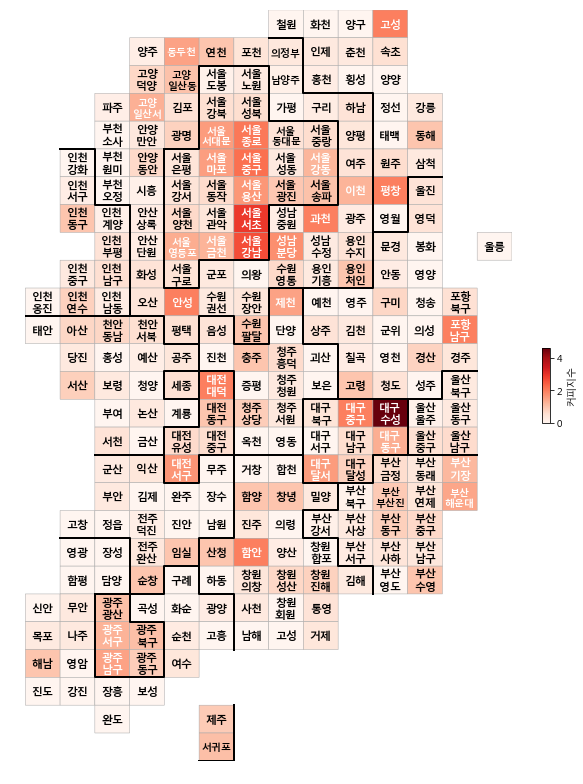

In [51]:
drawKorea('커피지수', coffee_index, 'Reds')

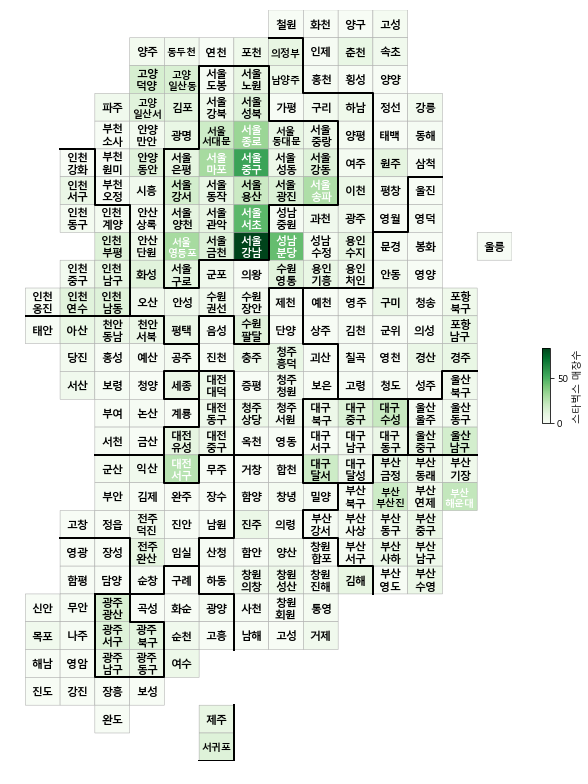

In [52]:
drawKorea('스타벅스 매장수', coffee_index, 'Greens')

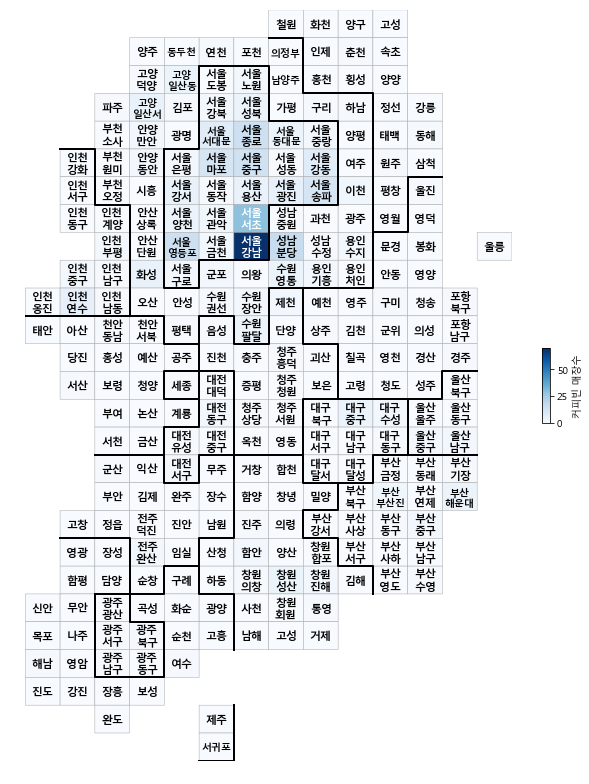

In [53]:
drawKorea('커피빈 매장수', coffee_index, 'Blues')

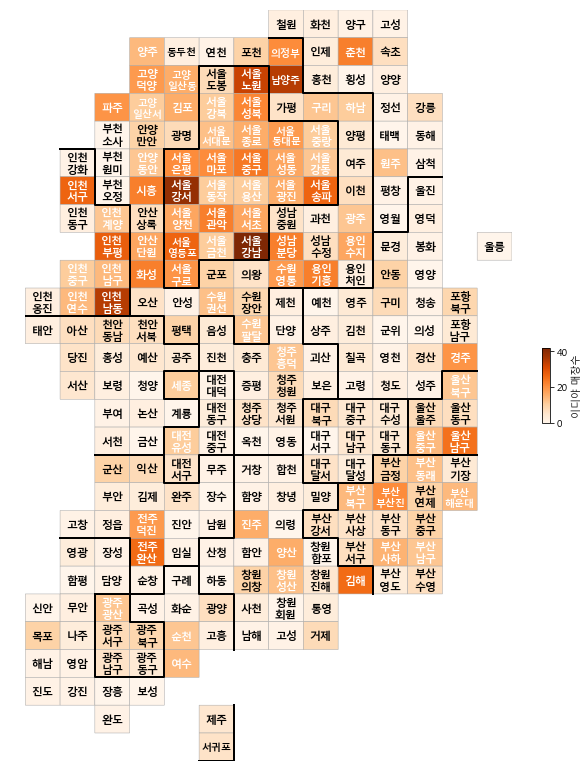

In [54]:
drawKorea('이디야 매장수', coffee_index, 'Oranges')

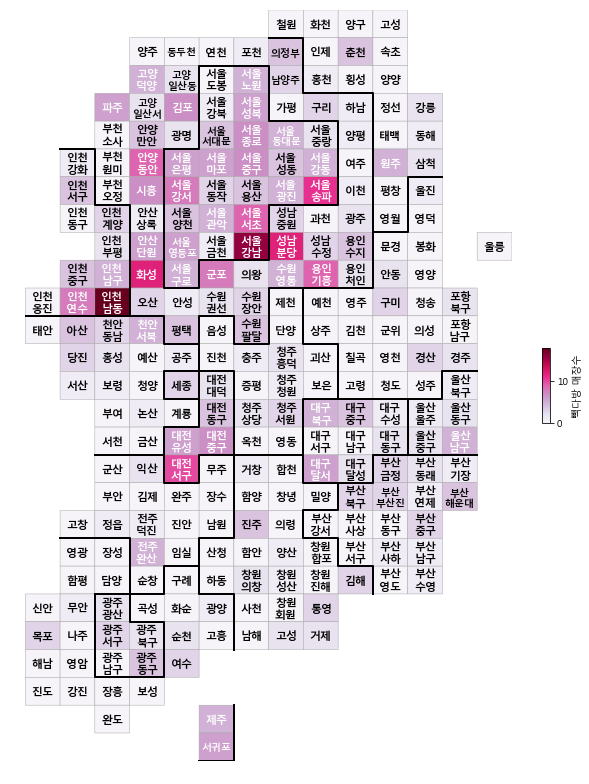

In [55]:
drawKorea('빽다방 매장수', coffee_index, 'PuRd')

## Top 5

In [56]:
# 커피지수 Top 5
coffee_index.sort_values(by='커피지수', ascending=False).head()

,y,x,ID,이디야 매장수,스타벅스 매장수,커피빈 매장수,빽다방 매장수,커피지수
153,14,10,대구 수성,4.0,21.0,2.0,1.0,4.600000
67,7,6,서울 서초,17.0,47.0,29.0,9.0,2.923077
77,8,6,서울 강남,42.0,84.0,70.0,16.0,2.655172
45,5,6,서울 중구,24.0,55.0,14.0,7.0,2.225806
34,4,6,서울 종로,16.0,33.0,15.0,7.0,2.086957


In [57]:
# 스타벅스 매장수 Top 5
coffee_index.sort_values(by='스타벅스 매장수', ascending=False).head()

,y,x,ID,이디야 매장수,스타벅스 매장수,커피빈 매장수,빽다방 매장수,커피지수
77,8,6,서울 강남,42.0,84.0,70.0,16.0,2.655172
45,5,6,서울 중구,24.0,55.0,14.0,7.0,2.225806
67,7,6,서울 서초,17.0,47.0,29.0,9.0,2.923077
78,8,7,성남 분당,23.0,45.0,17.0,12.0,1.771429
34,4,6,서울 종로,16.0,33.0,15.0,7.0,2.086957


In [58]:
# 커피빈 매장수 Top 5
coffee_index.sort_values(by='커피빈 매장수', ascending=False).head()

,y,x,ID,이디야 매장수,스타벅스 매장수,커피빈 매장수,빽다방 매장수,커피지수
77,8,6,서울 강남,42.0,84.0,70.0,16.0,2.655172
67,7,6,서울 서초,17.0,47.0,29.0,9.0,2.923077
78,8,7,성남 분당,23.0,45.0,17.0,12.0,1.771429
75,8,4,서울 영등포,27.0,30.0,15.0,6.0,1.363636
34,4,6,서울 종로,16.0,33.0,15.0,7.0,2.086957


In [59]:
# 이디야 매장수 Top 5
coffee_index.sort_values(by='이디야 매장수', ascending=False).head()

,y,x,ID,이디야 매장수,스타벅스 매장수,커피빈 매장수,빽다방 매장수,커피지수
77,8,6,서울 강남,42.0,84.0,70.0,16.0,2.655172
54,6,4,서울 강서,39.0,17.0,5.0,8.0,0.468085
97,10,2,인천 남동,35.0,13.0,1.0,18.0,0.264151
16,2,7,남양주,35.0,6.0,0.0,3.0,0.157895
15,2,6,서울 노원,33.0,9.0,2.0,5.0,0.289474


In [60]:
# 빽다방 매장수 Top 5
coffee_index.sort_values(by='빽다방 매장수', ascending=False).head()

,y,x,ID,이디야 매장수,스타벅스 매장수,커피빈 매장수,빽다방 매장수,커피지수
97,10,2,인천 남동,35.0,13.0,1.0,18.0,0.264151
77,8,6,서울 강남,42.0,84.0,70.0,16.0,2.655172
78,8,7,성남 분당,23.0,45.0,17.0,12.0,1.771429
86,9,3,화성,23.0,12.0,5.0,12.0,0.485714
58,6,8,서울 송파,27.0,28.0,12.0,11.0,1.052632
